# **Step 1: Import Libraries**

In [1]:
pip install fastai 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import zipfile
import torch
from torchvision.models import (
    swin_v2_t,
    Swin_V2_T_Weights,
)
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from glob import glob

**Ensure Reproducibility**

In [3]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

# **Step 2: Load Data**

In [4]:
# Zip path
# zip_path = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'

# Path to save extracted files
# extracted_path = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Create extraction directory if it doesn't exist
# os.makedirs(extracted_path, exist_ok=True)

# Extract the ZIP file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # zip_ref.extractall(extracted_path)

# **Step 3: Data Preprocessing**

In [5]:
# Labels all possible diseases
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted/Data_Entry_2017.csv')

# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding Labels'].map(lambda result: 1 if diseases in result else 0)

100%|██████████| 14/14 [00:00<00:00, 34.64it/s]


In [6]:
labels_df['Finding Labels'] = labels_df['Finding Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted/*/images/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image Index'].map(img_path.get)
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/chestX-ra...


# **Step 4: Exploratory Data Analysis (EDA)**

**Number of Patients**

In [7]:
unique_patients = np.unique(labels_df['Patient ID'])
len(unique_patients)

30805

# **Step 5: Split Dataset**

In [8]:
from sklearn.model_selection import train_test_split

# train-70
# val-10
# test-20
train_val_df_patients, test_df_patients = train_test_split(unique_patients, 
                                   test_size = 0.2,
                                   random_state = SEED,
                                    shuffle= True
                                   )
len(train_val_df_patients)

24644

In [9]:
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_df_patients)]

train_val_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/chestX-ra...


In [10]:
labels_df.shape
print('train_val size', train_val_df.shape[0])
print('test size', labels_df.shape[0] - train_val_df.shape[0])

train_val size 89826
test size 22294


In [11]:
import fastai
from fastai.vision.all import *

item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Paths']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=32)
# print(dblock.datasets(train_val_merge).train)

In [12]:
from fastai.vision.all import *
import torch
from torchvision.models import swin_v2_t, Swin_V2_T_Weights

# Step 1: Instantiate the Swin Transformer Tiny model with pretrained weights
model = swin_v2_t(weights=Swin_V2_T_Weights.IMAGENET1K_V1)

# Step 2: Modify the final layer to match the number of classes in your dataset
# Assume 'dls' is your DataLoaders object
num_classes = dls.c  # Number of classes
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Step 3: Define callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
]

# Step 4: Create the Fastai Learner with the custom model
learn = Learner(
    dls,
    model,
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],
    cbs=cbs,
    wd=0.001
)

# Optional: Wrap the model with DataParallel for multi-GPU training
learn.model = torch.nn.DataParallel(learn.model)

In [13]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-11-21 21:21:05.356896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 21:21:05.371885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732220465.387999 2426070 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732220465.392698 2426070 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 21:21:05.410200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  4


# **Step 5: Build the Model**

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

intial learning rate= 0.00010964782268274575


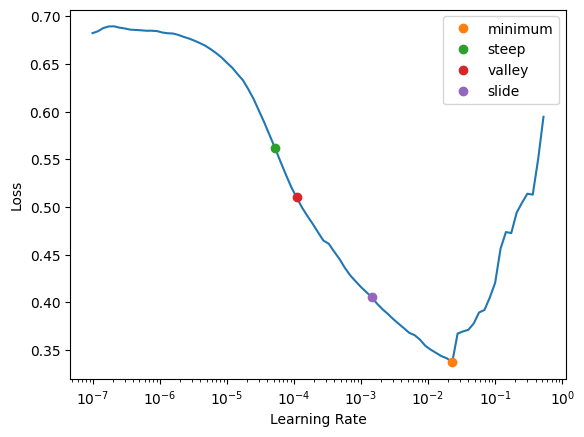

In [15]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

In [16]:
learn.fine_tune(freeze_epochs=3,epochs=10, base_lr=lrs.valley)

# **Step 6: Train the Model**

# **Step 7: Evaluate the Model**

In [ ]:
# TODO